## Welcome to Plotbot!

👋 Welcome to Plotbot! A your class-oriented workflow optimizer for downloading and plotting data from the Parker Solar Probe. Created by Dr. Jaye Verniero and Dr. Robert Alexander. Note: this is a work in progress.

⚡️Plotbot utilizes active calculation caching⚡️
   ⚡️Calculate once and forget about it⚡️

First, click in the upper right hand corner of this window to select the plotbot environment. It should be named plotbot_env (Python 3.12.4). Alternatively, you'll be prompted to select the environment when you run the first cell below.







### Plotbot

Let's get started by importing plotbot:

In [1]:
#Remember to select the Plotbot Environment!
from plotbot import *


🕒 Starting import timing session: plotbot_full_initialization
  ✅ matplotlib.pyplot: 0.311s
  ✅ numpy: 0.000s
  🔧 Starting block: core_components
initialized server_access
initialized global_tracker
initialized ploptions
initialized plot_manager
initialized epad class
initialized epad_hr class
initialized proton class
initialized proton_hr class
initialized ham_class
initialized psp_alpha class
initialized psp_qtn class
initialized psp_orbit class
initialized psp_span_vdf class
initialized data_cubby.
CDF classes added to data_cubby type map.
  ✅ Block 'core_components' completed in 0.773s
  🔧 Starting block: psp_data_classes
initialized proton_fits class
initialized alpha_fits class
  ✅ Block 'psp_data_classes' completed in 0.001s
  🔧 Starting block: wind_data_classes
  ✅ Block 'wind_data_classes' completed in 0.000s
  🔧 Starting block: custom_cdf_classes
  ✅ Block 'custom_cdf_classes' completed in 0.000s
  🔧 Starting block: data_cubby_registration
  ✅ Block 'data_cubby_registration'

#### ✨ The Data Snapshot! Save All Current Calculations to .pkl✨

In [2]:
# #Uncomment to explore the data snapshot!

# #Never wait for calculations again!
# #At the end of your session, save your cache'd calculations to a .pkl file:
# save_simple_snapshot('my_calculated_data.pkl') 

# # Load the cache at the beginning of your next session like this: 
# load_simple_snapshot('my_calculated_data.pkl') 

# # And the best part? Any new calculations will automatically be
# # merged with your import, and you can just save again at the
# # end of your next session!

#### ✨Diving In✨

In [3]:
print_manager.show_status = True
print_manager.show_debug = False
print_manager.show_processing = False
print_manager.show_data_cubby = False
print_manager.show_time_tracking = False

In [4]:
config.data_server = 'berkeley'
# config.data_server = 'spdf'
# config.data_server = 'dynamic'  #<--default to SPDF with Berkeley as a secondary choice

In [5]:
# config.data_dir = 'default'
config.data_dir =  'custom_data_dir'

🤖 Plotbot starting (loading scientific libraries)...
🤖 Plotbot libraries loaded, proceeding...
🛰️ mag_SC_4sa - acquiring variables: bx
 
📥 Acquiring data for 1 regular variables...
🕒 TimeRangeTracker: Stored trange ['2021/04/26 00:00:00.000', '2021/04/27 00:00:00.000']
🛰️ mag_SC_4sa - acquiring variables: bx
Attempting Berkeley acquisition path for mag_SC_4sa...
📡 mag_SC_4sa - A local .cdf file already exists:
📂 custom_data_dir/psp/fields/l2/mag_sc_4_per_cycle/2021/psp_fld_l2_mag_SC_4_Sa_per_Cyc_20210426_v02.cdf
☑️ - CDF Data import complete for mag_SC_4sa range ['2021/04/26 00:00:00', '2021/04/27 00:00:00'].

📥 Requesting DataCubby to update/merge global instance for mag_sc_4sa...
✅ DataCubby processed update for mag_sc_4sa.
✅ Complete
📈 Plotting mag_sc_4sa.bx


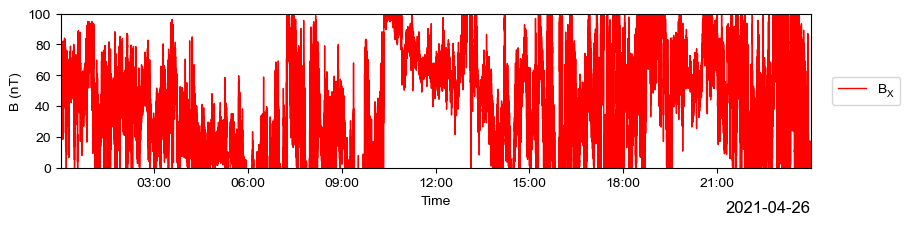

Shape of mag_sc_4sa.bx.data: (395507,)


In [6]:
plt.options.reset()

trange = ['2021/04/26 00:00:00.000', '2021/04/27 00:00:00.000']

mag_sc_4sa.bx.y_limit = [0, 100]

plotbot(trange, mag_sc_4sa.bx, 1)

print("Shape of mag_sc_4sa.bx.data:", getattr(mag_sc_4sa.bx, 'data', None).shape if hasattr(mag_sc_4sa.bx, 'data') and mag_sc_4sa.bx.data is not None else "Attribute 'data' not found or is None")


🤖 Plotbot starting (loading scientific libraries)...
🤖 Plotbot libraries loaded, proceeding...
🛰️ spe_sf0_pad - acquiring variables: strahl
🛰️ spi_sf00_l3_mom - acquiring variables: energy_flux
🛰️ mag_RTN_4sa - acquiring variables: br
 
📥 Acquiring data for 3 regular variables...
🕒 TimeRangeTracker: Stored trange ['2018-10-22 12:00:00', '2018-10-27 13:00:00']
🛰️ spe_sf0_pad - acquiring variables: strahl
🛰️ spi_sf00_l3_mom - acquiring variables: energy_flux
🛰️ mag_RTN_4sa - acquiring variables: br
Attempting Berkeley acquisition path for spe_sf0_pad...
📡 spe_sf0_pad - Local .cdf files already exist:
📂 custom_data_dir/psp/sweap/spe/l3/spe_sf0_pad/2018/psp_swp_spe_sf0_L3_pad_20181022_v04.cdf, custom_data_dir/psp/sweap/spe/l3/spe_sf0_pad/2018/psp_swp_spe_sf0_L3_pad_20181023_v04.cdf, custom_data_dir/psp/sweap/spe/l3/spe_sf0_pad/2018/psp_swp_spe_sf0_L3_pad_20181024_v04.cdf, custom_data_dir/psp/sweap/spe/l3/spe_sf0_pad/2018/psp_swp_spe_sf0_L3_pad_20181025_v04.cdf, custom_data_dir/psp/sweap/sp

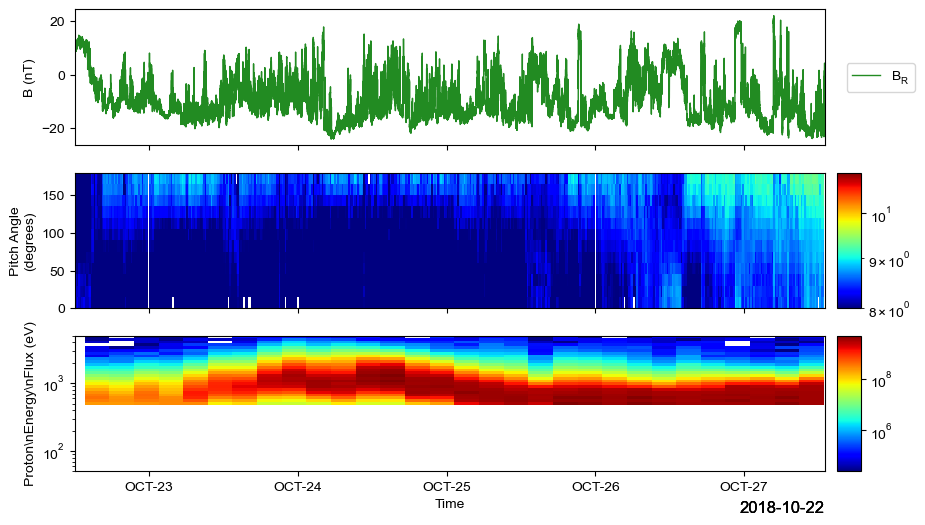

Shape of mag_rtn_4sa.br.data: (997007,)
Shape of epad.strahl.data: (5832, 12)


In [7]:
#--------//

trange = ['2018-10-22 12:00:00', '2018-10-27 13:00:00']

epad.strahl.colorbar_limits = [8, 11]
epad.strahl.colorbar_scale = 'log'

plotbot(trange, mag_rtn_4sa.br, 1, epad.strahl, 2, proton.energy_flux, 3)

print("Shape of mag_rtn_4sa.br.data:", getattr(mag_rtn_4sa.br, 'data', None).shape if hasattr(mag_rtn_4sa.br, 'data') and mag_rtn_4sa.br.data is not None else "Attribute 'data' not found or is None")

print("Shape of epad.strahl.data:", getattr(epad.strahl, 'data', None).shape if hasattr(epad.strahl, 'data') and epad.strahl.data is not None else "Attribute 'data' not found or is None")


In [9]:
print_manager.show_status = False
print_manager.show_debug = False
# TRANGE = ['2023-09-28/00:00:00.000', '2023-09-29/00:00:00.000'] # 1 day
# plotbot(TRANGE, mag_rtn_4sa.br, 1, proton.anisotropy, 2, mag_rtn_4sa.br_norm, 3, epad.strahl, 4)
# plotbot(TRANGE, mag_rtn.br, 1, proton.anisotropy, 2, mag_rtn.br_norm, 3, epad.strahl, 4)

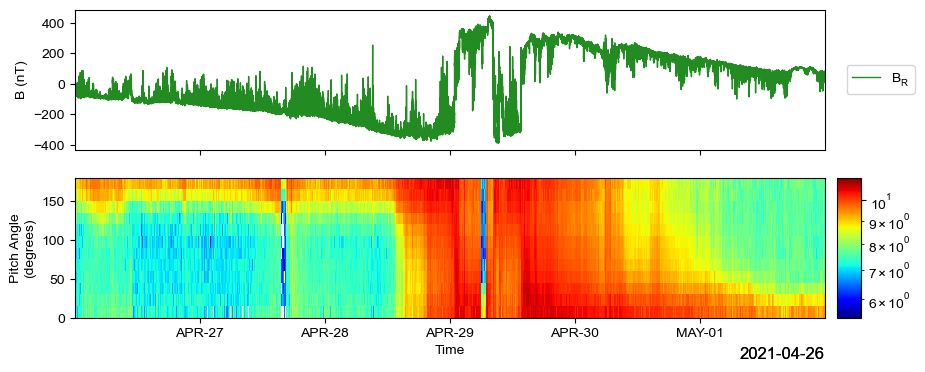

In [10]:
plt.options.reset()
#----Print manager----/// ✨ Two levels of print manager verbosity
print_manager.show_status = False
print_manager.show_debug = False

#an example for how to use the pb.config to change the data server setting
config.data_server = 'berkeley' #<--default to SPDF with Berkeley as a secondary choice
# Server options are 'dynamic', 'spdf' or 'berkeley'

print_manager.show_status = False

Jaye_epad_trange = ['2021/04/26 00:00:00.000', '2021/05/2 00:00:00.000']
plotbot(Jaye_epad_trange, mag_rtn_4sa.br, 1, epad.strahl, 2)

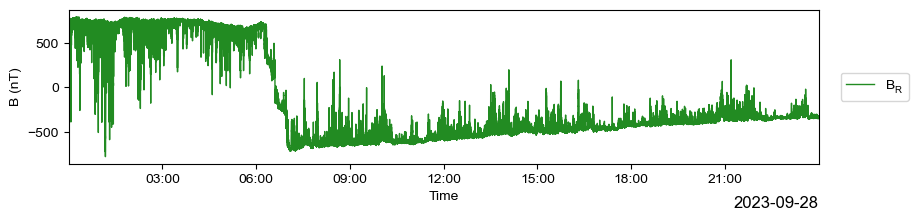

In [ ]:
TRANGE = ['2023-09-28/00:00:00.000', '2023-09-29/00:00:00.000'] # 1 day
plotbot(TRANGE, mag_rtn_4sa.br, 1)

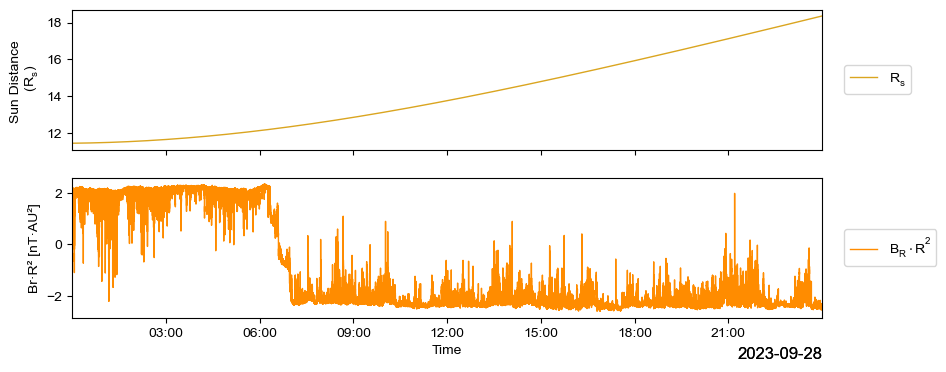

In [ ]:
TRANGE = ['2023-09-28/00:00:00.000', '2023-09-29/00:00:00.000'] # 1 day
plotbot(TRANGE, proton.sun_dist_rsun, 1, mag_rtn_4sa.br_norm, 2)

In [ ]:
# # ✨ Using the original import style for the remainder of the notebook 
# import plotbot
# from plotbot import *

In [ ]:
config.data_server = 'dynamic' # Berkeley is generally the faster way to go!

In [ ]:
#----Print manager----/// ✨ All the available print manager options 

print_manager.show_status = False  # Status prints ⭐️ useful for basic status updates

print_manager.show_debug = False  # Debug prints, helpful for debugging (will print a LOT of information)

print_manager.pyspedas_verbose = False

print_manager.show_processing = False # e.g. Processing mag_RTN_4sa...

print_manager.show_custom_debug = False  # Custom variable operations debugging

print_manager.show_time_tracking = False  # For tracking datetime array inputs and outputs
print_manager.show_warning = False     # Turn off warning messages
print_manager.show_variable_testing = False
print_manager.show_test = False  # Turn off test-specific output

print_manager.show_module_prefix = False  # Show/Hide [print_manager]
print_manager.show_category_prefix = False  # Show/Hide [PROCESS], [TIME], etc.

## Proton Fits! (Local CSV required)

🤖 Plotbot starting (loading scientific libraries)...
🤖 Plotbot libraries loaded, proceeding...
🛰️ proton_fits - acquiring variables: abs_qz_p, vdrift_va_pfits, valfven_pfits, beta_ppar_pfits, beta_pperp_pfits
 
📥 Acquiring data for 5 regular variables...
🕒 TimeRangeTracker: Stored trange ['2024-09-30/11:45:00.000', '2024-09-30/12:45:00.000']
🛰️ proton_fits - calculation may be needed
✅ - FITS raw data import complete for range ['2024-09-30/11:45:00.000', '2024-09-30/12:45:00.000'].

📥 Updating proton_fits with calculated data...
☑️ - CDF Data import complete for spi_sf00_l3_mom range ['2024-09-30/00:00:01.536000', '2024-09-30/23:59:54.893000'].

✅ Complete
📈 Plotting proton_fits.abs_qz_p
📈 Plotting proton_fits.vdrift_va_pfits
📈 Plotting proton_fits.valfven_pfits
📈 Plotting proton_fits.beta_ppar_pfits
📈 Plotting proton_fits.beta_pperp_pfits


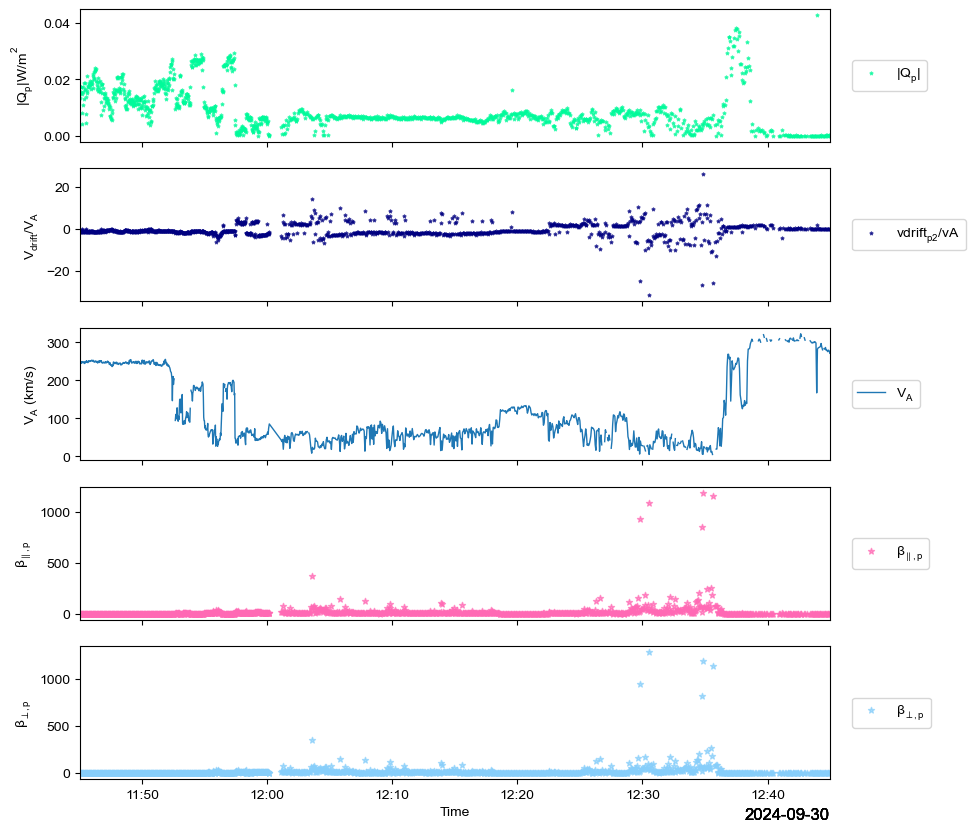

In [ ]:
## Example of new proton fits naming convention!

print_manager.show_status = True
fits_trange = ['2024-09-30/11:45:00.000', '2024-09-30/12:45:00.000']

# data_snapshot.save_data_snapshot('project_data.pkl')

plotbot(fits_trange, proton_fits.abs_qz_p, 1, proton_fits.vdrift_va_pfits, 2, proton_fits.valfven_pfits, 3, proton_fits.beta_ppar_pfits, 4, proton_fits.beta_pperp_pfits, 5)


## Generate Plots from HAM Files (Local CSV required)

🤖 Plotbot starting (loading scientific libraries)...
🤖 Plotbot libraries loaded, proceeding...
🛰️ proton_fits - acquiring variables: np1, ham_param, Tperp1, vdrift_va_pfits
 
proton_fits already calculated for the time range: 2024-09-30/11:45:00.000 to 2024-09-30/12:45:00.000
proton_fits already calculated for the time range: 2024-09-30/11:45:00.000 to 2024-09-30/12:45:00.000
proton_fits already calculated for the time range: 2024-09-30/11:45:00.000 to 2024-09-30/12:45:00.000
proton_fits already calculated for the time range: 2024-09-30/11:45:00.000 to 2024-09-30/12:45:00.000
✅ All data already cached for 4 regular variables in the specified trange.
🕒 TimeRangeTracker: Stored trange ['2024-09-30/11:45:00.000', '2024-09-30/12:45:00.000']
📈 Plotting proton_fits.np1
📈 Plotting proton_fits.ham_param
📈 Plotting proton_fits.Tperp1
📈 Plotting proton_fits.vdrift_va_pfits


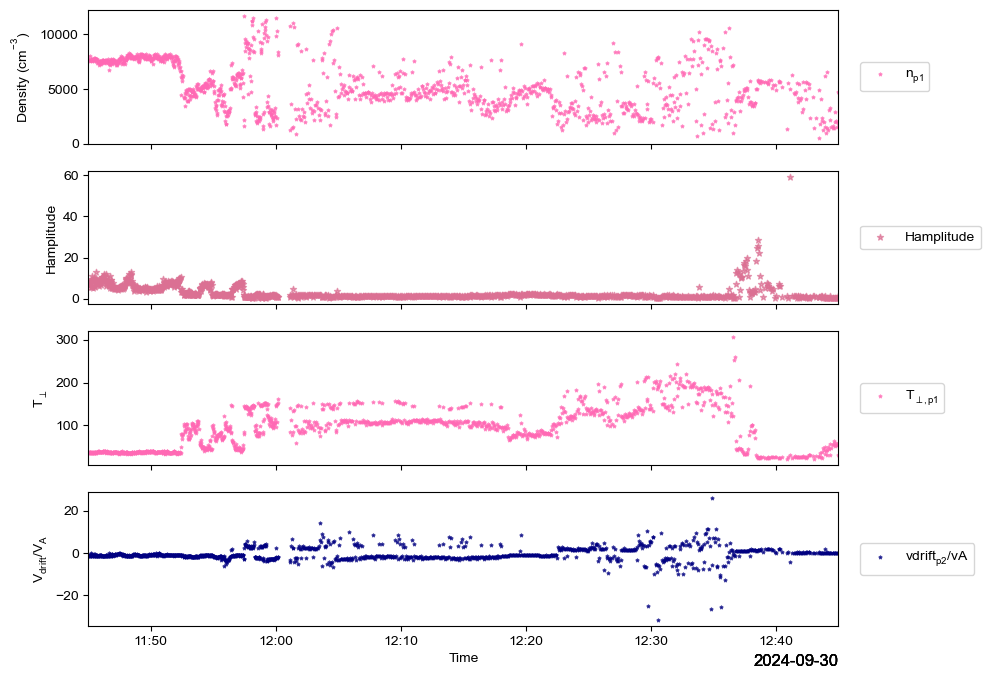

In [ ]:
#Example HAM 🍖 and fits plotbot calls!
plt.options.reset() 

print_manager.show_status = True  # Status prints, ⭐️ useful for basic status updates
print_manager.show_debug = False  # Debug prints, helpful for debugging (will print LOTS of lines)

%matplotlib inline 
# %matplotlib widget

# ham_trange = ['2025-03-23 11:00:00.000', '2025-03-23 12:00:00.000']

#server_access.username = 'your_username_here'

# ham.trat_ham.y_limit = [0, 50]

# plotbot(ham_trange, ham.trat_ham, 1)

fits_trange = ['2024-09-30/11:45:00.000', '2024-09-30/12:45:00.000']

plotbot(fits_trange, proton_fits.np1, 1, proton_fits.ham_param, 2, proton_fits.Tperp1, 3, proton_fits.vdrift_va_pfits, 4)

🤖 Plotbot starting (loading scientific libraries)...
🤖 Plotbot libraries loaded, proceeding...
🛰️ ham - acquiring variables: hamogram_30s
🛰️ spi_sf00_l3_mom - acquiring variables: m_alfven, density, bmag, sun_dist_rsun
 
📥 Acquiring data for 5 regular variables...
🕒 TimeRangeTracker: Stored trange ['2025-03-19 00:00:00.000', '2025-03-27 23:59:59.000']
🛰️ ham - acquiring variables: hamogram_30s
🛰️ spi_sf00_l3_mom - acquiring variables: m_alfven, density, bmag, sun_dist_rsun
Successfully loaded Hammerhead data with 246673 time points
📥 Requesting DataCubby to update/merge global instance for ham...
✅ DataCubby processed update for ham.
Attempting SPDF acquisition path (dynamic mode) for spi_sf00_l3_mom...


04-Sep-25 17:31:50: Remote index not found: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/
04-Sep-25 17:31:52: Skipping remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/ (previous attempt failed)
04-Sep-25 17:31:52: Skipping remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/ (previous attempt failed)
04-Sep-25 17:31:52: Skipping remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/ (previous attempt failed)
04-Sep-25 17:31:52: Skipping remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/ (previous attempt failed)
04-Sep-25 17:31:52: Skipping remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/ (previous attempt failed)
04-Sep-25 17:31:52: Skipping remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/ (previous attempt failed)
04-Sep-25 17:31:5

SPDF acquisition path failed/incomplete for spi_sf00_l3_mom, falling back to Berkeley...
📡 spi_sf00_l3_mom - Local .cdf files already exist:
📂 data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/psp_swp_spi_sf00_l3_mom_20250319_v00.cdf, data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/psp_swp_spi_sf00_l3_mom_20250320_v00.cdf, data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/psp_swp_spi_sf00_l3_mom_20250321_v00.cdf, data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/psp_swp_spi_sf00_l3_mom_20250322_v00.cdf, data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/psp_swp_spi_sf00_l3_mom_20250323_v00.cdf, data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/psp_swp_spi_sf00_l3_mom_20250324_v00.cdf, data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/psp_swp_spi_sf00_l3_mom_20250325_v00.cdf, data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/psp_swp_spi_sf00_l3_mom_20250326_v00.cdf, data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/psp_swp_spi_sf00_l3_mom_20250327_v00.cdf
☑️ - CDF Data import complete for spi_sf00_l3_mom range ['2025-03-19 00:00:00', '2025-03-27 2

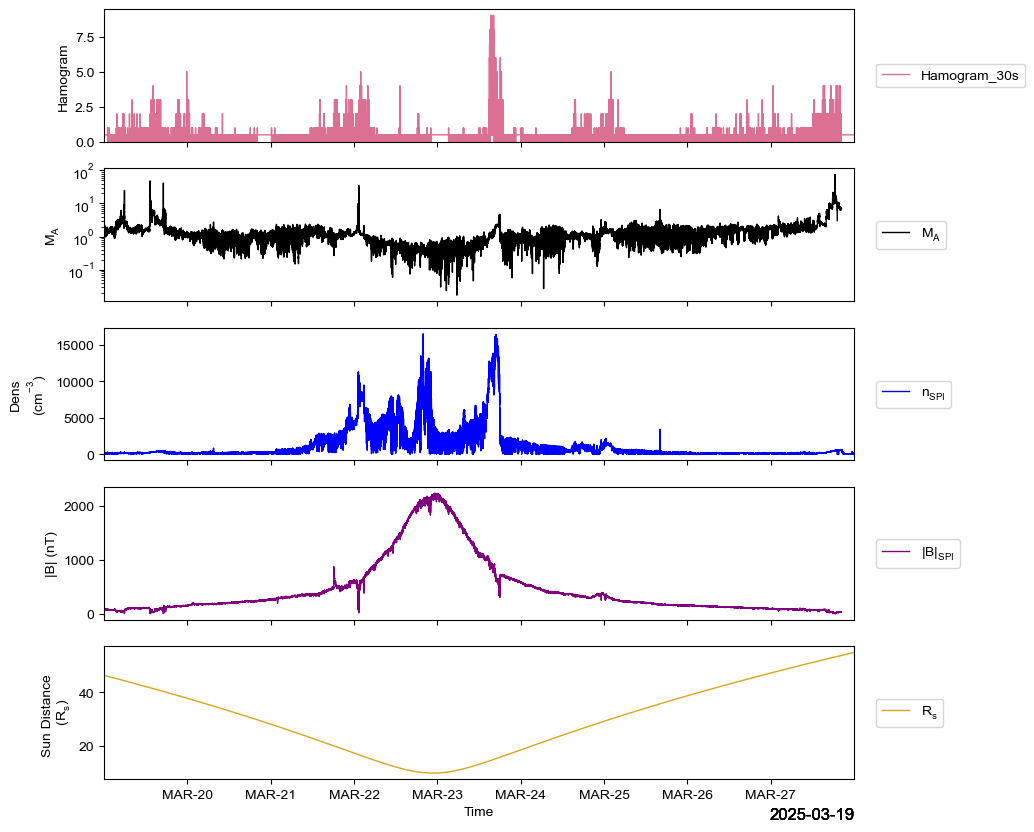

In [ ]:
print_manager.show_status = True
print_manager.show_debug = False
trange = ['2025-03-19 00:00:00.000', '2025-03-27 23:59:59.000']
plotbot(trange,
        ham.hamogram_30s, 1,
        proton.m_alfven, 2,
        proton.density,3,
        proton.bmag,4,
        proton.sun_dist_rsun, 5)

## Interactive Plotting


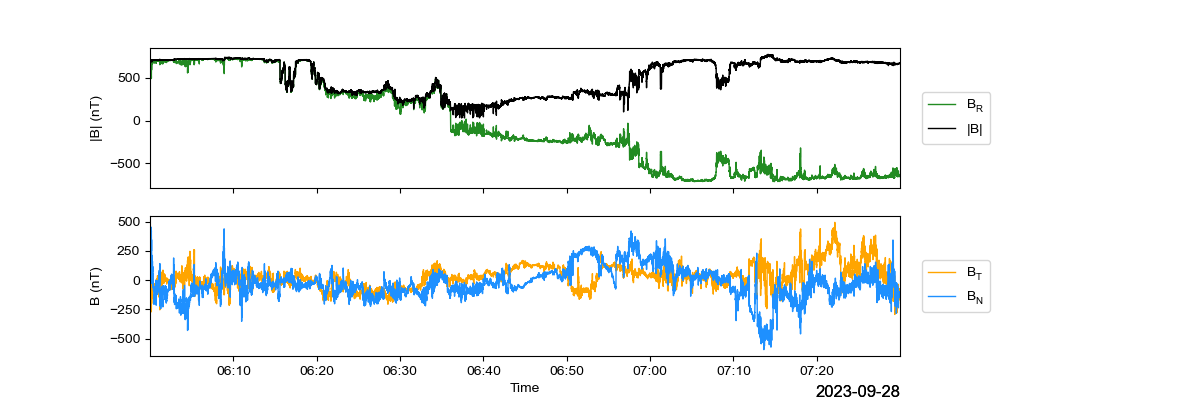

In [ ]:
print_manager.show_status = False # Status prints, ⭐️ useful for basic status updates

#Use inline for static plots and widget for interactive plots
#The panel at the left has options for moving and zooming the plot
# %matplotlib inline 
%matplotlib widget

#E17 HCS Crossing

server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

epad.strahl.colorbar_limits = 'default'
epad.strahl.colorbar_scale = 'log'

trange = ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000']  # Enc 17 HCS Crossing


plotbot(trange, mag_rtn_4sa.br, 1, mag_rtn_4sa.bmag, 1, mag_rtn_4sa.bt, 2, mag_rtn_4sa.bn, 2)


ValueError: x and y must be the same size

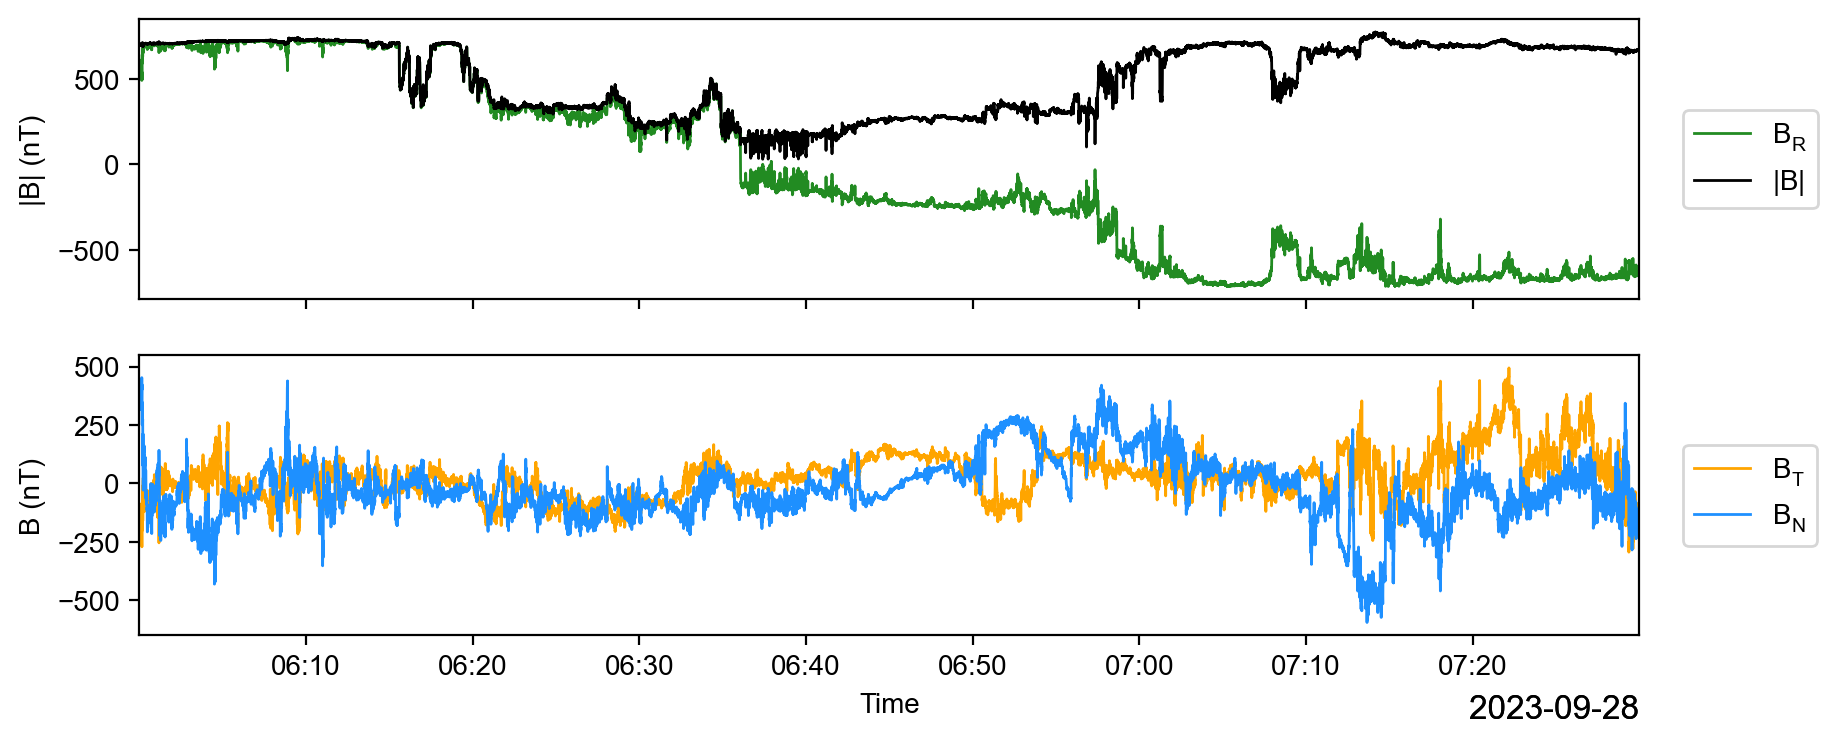

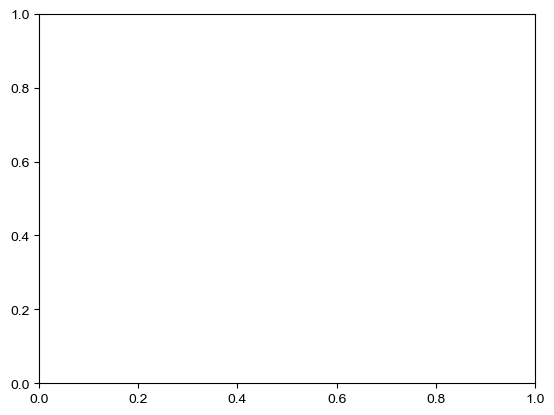

In [ ]:
#Plot Hodograms with Custom Variables and Showdahodo

print_manager.show_status = False  # Status prints, ⭐️ useful for basic status updates

#Use inline for static plots and widget for interactive plots
%matplotlib inline 
# %matplotlib widget

# Define a time range
trange = ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000']
# trange = ['2023-10-28/06:00:00.000', '2023-10-28/07:30:00.000']

# Create a custom variable with our elegant syntax
TAplusBmag = custom_variable('TAplusBmag', proton.anisotropy + mag_rtn_4sa.bmag)

# Then use showdahodo with proton.beta_ppar on x-axis and proton.anisotropy on y-axis
# showdahodo(trange, TAplusBmag, proton.anisotropy, brazil=True);
showdahodo(trange, TAplusBmag, proton.anisotropy);

In [ ]:
# #An example with password protected data

# #E21 Glory Region! 
# print_manager.show_status = False  # Status prints, useful for status updates
# print_manager.show_debug = False   # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

# epad.strahl.colorbar_limits = [10.4, 11]
# epad.strahl.colorbar_scale = 'log'

# trange = ['2024-09-30/12:10:00.000', '2024-09-30/12:20:00.000']
# # plotbot(trange, mag_rtn_4sa.all, 1, mag_rtn_4sa.bmag, 1, 
# #         epad_hr.strahl, 2, 
# #         proton_hr.energy_flux, 3, 
# #         proton_hr.t_perp, 4, 
# #         proton_hr.t_par, 4, proton_hr.anisotropy, '4r', 
# #         proton_hr.v_sw, 5, proton_hr.v_alfven, '5r')

# plotbot(trange, mag_rtn_4sa.br, 1, mag_rtn_4sa.bmag, 1, 
#         mag_rtn_4sa.bt, 2, mag_rtn_4sa.bn, 2, 
#         epad.strahl, 3, 
#         proton.energy_flux, 4, 
#         proton.theta_flux, 5, 
#         proton.phi_flux, 6, 
#         proton.t_perp, 7, 
#         proton.t_par, 7, proton.anisotropy, '7r', 
#         proton.v_sw, 8, proton.v_alfven, 8)

## Math with Plotbot.data

=== Magnetic Field Data Analysis ===

UPDATE GLOBAL ERROR - Error calling update() on instance: name 'np' is not defined
[mag_rtn_4sa getattr] 'np' is not a recognized attribute, friend!
[mag_rtn_4sa getattr] Try one of these: all, br, bt, bn, bmag, pmag, br_norm
Traceback (most recent call last):
  File "/Users/robertalexander/GitHub/Plotbot/plotbot/data_cubby.py", line 954, in update_global_instance
    global_instance.update(imported_data_obj, original_requested_trange=original_requested_trange)
  File "/Users/robertalexander/GitHub/Plotbot/plotbot/data_classes/psp_mag_rtn_4sa.py", line 90, in update
    self.calculate_variables(imported_data)                                # Update raw data arrays
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/robertalexander/GitHub/Plotbot/plotbot/data_classes/psp_mag_rtn_4sa.py", line 295, in calculate_variables
    self.time = np.asarray(imported_data.times)
                ^^
NameError: name 'np' is not defined. Did you mean: 'self.

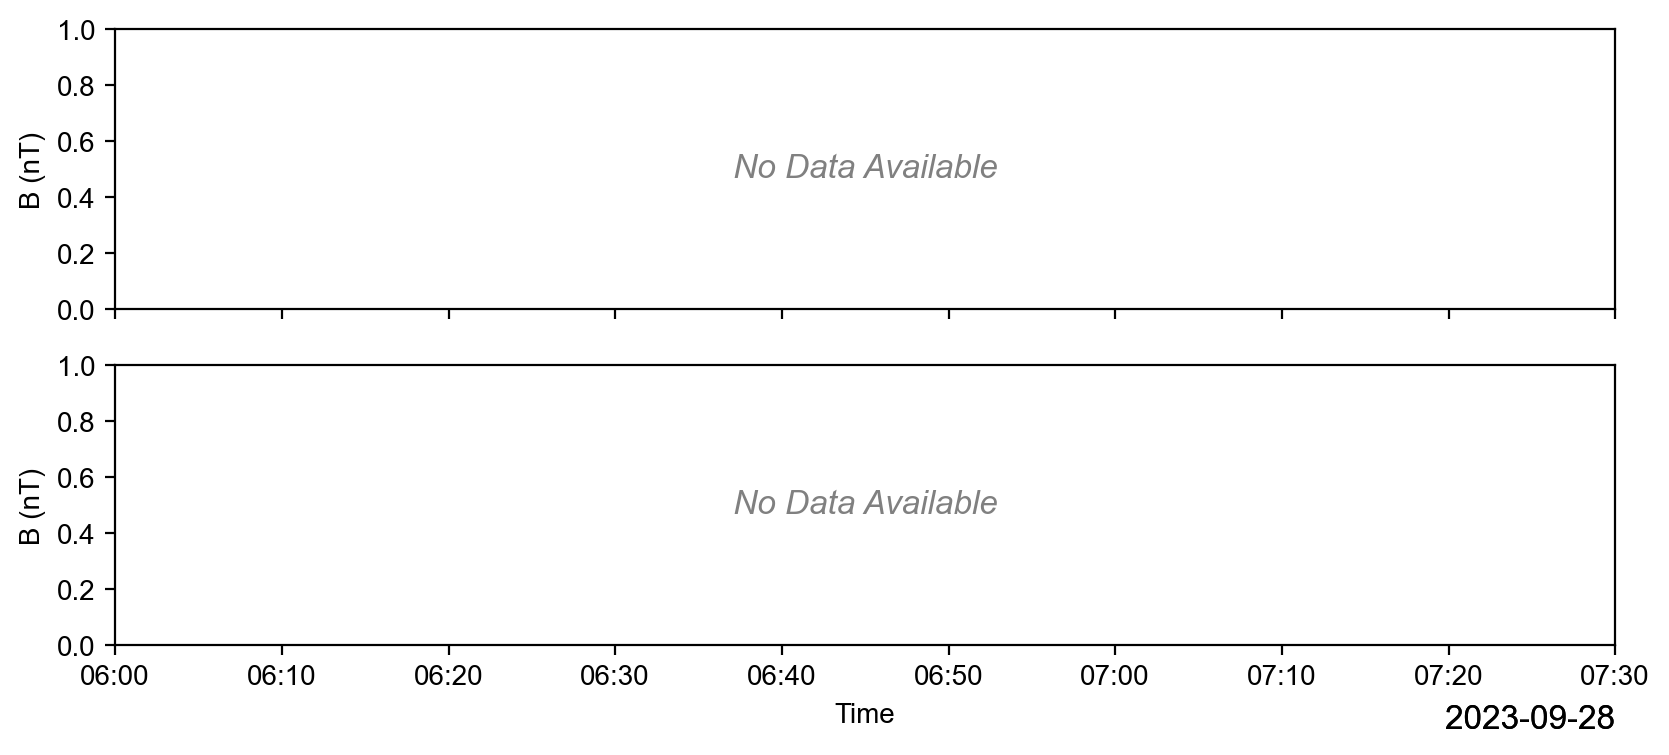

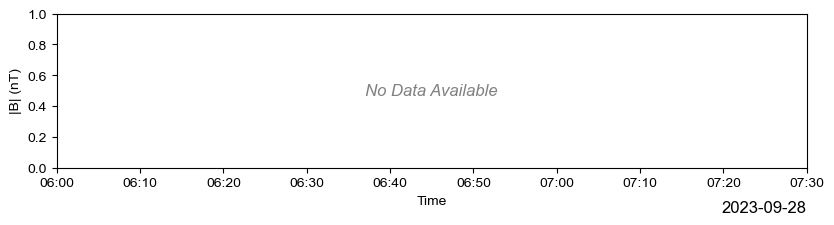

1. Data Structure Checks:
Data type: <class 'plotbot.plot_manager.plot_manager'>
Shape: ()


TypeError: len() of unsized object

In [ ]:
#Working with Plotbot.data!! (the format is actually "mag_rtn_4sa.bmag.data " but you know what I mean...)

# Statistical Analysis of Magnetic Field Data
print("=== Magnetic Field Data Analysis ===\n")

trange = ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000']  # Enc 17 HCS Crossing

plotbot(trange, mag_rtn_4sa.bmag, 1)

# Convert plot_manager objects to numpy arrays for analysis
bmag_data = mag_rtn_4sa.bmag.data  
br_data = mag_rtn_4sa.br.data
bt_data = mag_rtn_4sa.bt.data
bn_data = mag_rtn_4sa.bn.data

# Basic checks
print("1. Data Structure Checks:")
print(f"Data type: {type(mag_rtn_4sa.bmag)}")
print(f"Shape: {np.shape(bmag_data)}")
print(f"Number of points: {len(bmag_data)}")
print(f"Memory usage: {bmag_data.nbytes / 1e6:.2f} MB\n")

# Basic statistics
print("2. Basic Statistics:")
print(f"Mean |B|: {np.nanmean(bmag_data):.2f} nT")
print(f"Median |B|: {np.nanmedian(bmag_data):.2f} nT")
print(f"Standard deviation: {np.nanstd(bmag_data):.2f} nT")
print(f"Min |B|: {np.nanmin(bmag_data):.2f} nT")
print(f"Max |B|: {np.nanmax(bmag_data):.2f} nT\n")

# Component analysis
print("3. Component Analysis:")
print("Mean values:")
print(f"⟨Br⟩: {np.nanmean(br_data):.2f} nT")
print(f"⟨Bt⟩: {np.nanmean(bt_data):.2f} nT")
print(f"⟨Bn⟩: {np.nanmean(bn_data):.2f} nT\n")

# Calculate field angles
theta = np.arctan2(np.sqrt(bt_data**2 + bn_data**2), br_data)
phi = np.arctan2(bn_data, bt_data)

print("4. Field Orientation:")
print(f"Mean θ (from radial): {np.degrees(np.nanmean(theta)):.2f}°")
print(f"Mean φ (azimuthal): {np.degrees(np.nanmean(phi)):.2f}°\n")

# Power and energy density
mu0 = 4 * np.pi * 1e-7  # permeability of free space
B_squared = bmag_data**2
energy_density = B_squared / (2 * mu0) * 1e-9  # Convert to J/m^3

print("5. Energy Analysis:")
print(f"Mean B²: {np.nanmean(B_squared):.2f} nT²")
print(f"Mean magnetic energy density: {np.nanmean(energy_density):.2e} J/m³\n")

# Time series analysis
if hasattr(mag_rtn_4sa, 'datetime_array'):
    print("6. Time Series Properties:")
    # Convert datetime array to numeric values for time difference calculation
    time_array = np.array(mag_rtn_4sa.datetime_array, dtype='datetime64[ns]')
    time_diffs = np.diff(time_array)
    mean_cadence_ns = np.mean(time_diffs)
    mean_cadence_s = mean_cadence_ns / np.timedelta64(1, 's')  # Convert to seconds
    print(f"Mean sampling cadence: {mean_cadence_s:.6f} seconds")
    
    # Calculate power spectrum using sampling frequency in Hz
    from scipy import signal
    fs = 1.0 / mean_cadence_s
    # Remove NaN values for spectrum calculation
    valid_data = bmag_data[~np.isnan(bmag_data)]
    if len(valid_data) > 0:
        f, Pxx = signal.welch(valid_data - np.mean(valid_data), fs=fs)
        peak_freq = f[np.argmax(Pxx)]
        print(f"Dominant frequency in power spectrum: {peak_freq:.2e} Hz\n")

# Data quality checks
print("7. Data Quality Metrics:")
print(f"Number of NaN values: {np.sum(np.isnan(bmag_data))}")
print(f"Number of zeros: {np.sum(bmag_data == 0)}")
print(f"Number of values > 3σ: {np.sum(np.abs(bmag_data - np.nanmean(bmag_data)) > 3*np.nanstd(bmag_data))}\n")

# Visualization
plt.figure(figsize=(12, 8))

# Plot 1: Histogram of |B|
plt.subplot(221)
plt.hist(bmag_data[~np.isnan(bmag_data)], bins=50, density=True)
plt.title('|B| Distribution')
plt.xlabel('|B| (nT)')
plt.ylabel('Density')

# Plot 2: Component correlations
plt.subplot(222)
mask = ~np.isnan(br_data) & ~np.isnan(bt_data)
plt.scatter(br_data[mask], bt_data[mask], alpha=0.1)
plt.xlabel('Br (nT)')
plt.ylabel('Bt (nT)')
plt.title('Br vs Bt')

# Plot 3: Field angle distribution
plt.subplot(223)
mask = ~np.isnan(theta) & ~np.isnan(phi)
plt.hist2d(np.degrees(theta[mask]), np.degrees(phi[mask]), bins=50)
plt.xlabel('θ (degrees)')
plt.ylabel('φ (degrees)')
plt.title('Field Angle Distribution')
plt.colorbar()

# Plot 4: Power spectrum
plt.subplot(224)
if hasattr(mag_rtn_4sa, 'datetime_array'):
    valid_data = bmag_data[~np.isnan(bmag_data)]
    if len(valid_data) > 0:
        plt.loglog(f, Pxx)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectral Density')
        plt.title('Power Spectrum')

plt.tight_layout()
plt.show()